<a href="https://colab.research.google.com/github/rushil23451/ML4SCI_-Evaluation-Test-DeepFalcon/blob/main/Evaluation_Test_DeepFalcon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

POINT TO NOTE-> 1) I HAD UPLAODED THE DATASET DIRECTLY ON MY GOOGLE DRIVE AND ACCESSING THE DATA FROM THERE ONLY SO IF YOU DONT HAVE THE DATA FILE ON GOOGLE DRIVE UPLOAD IT THERE OR EITHER UPLOAD IT ON THE NOTEBOOK BUT CHANGE THE PATH

# Q1)->.
Common Task 1. Auto-encoder of the quark/gluon events

Please train a variational auto-encoder to learn the representation based on three image channels (ECAL, HCAL and Tracks) for the dataset.

Please show a side-by-side comparison of original and reconstructed events.


In [ ]:
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0
!pip install matplotlib==3.7.1 scikit-learn==1.2.2 pandas h5py
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from sklearn.model_selection import train_test_split
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {str(e)}")

# Set random seeds for reproducibility
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


class ConvVariationalAutoencoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=32, input_size=(125, 125)):
        super(ConvVariationalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 125x125 -> 63x63
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 63x63 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )

        # Calculate the output size after encoder
        self.encoder_output_size = self._get_encoder_output_size(in_channels, input_size)
        self.flatten_size = np.prod(self.encoder_output_size)

        # Latent space projection
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # Decoder input layer
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Sigmoid()
        )

    def _get_encoder_output_size(self, in_channels, input_size):
        """Calculate encoder output size without using a dummy tensor (memory efficient)"""
        # Manual calculation of the output size after 5 layers of stride 2 convolutions
        h, w = input_size
        for _ in range(5):  # 5 conv layers with stride 2
            h = (h + 2*1 - 4) // 2 + 1
            w = (w + 2*1 - 4) // 2 + 1
        return (512, h, w)  # 512 is the number of channels in the last encoder layer

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # Clip log_var for numerical stability
        log_var = torch.clamp(log_var, min=-20, max=20)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), *self.encoder_output_size)
        x = self.decoder(x)
        # Resize to match original dimensions (125x125)
        x = F.interpolate(x, size=(125, 125), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var



def kl_divergence_loss(mu, log_var):
    """
    Compute KL divergence loss
    """
    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl_loss

def vae_loss(reconstruction, original, mu, log_var, kl_weight=0.001):
    """
    Physics-aware VAE loss that gives higher importance to high-energy deposits
    """
    # Create importance weighting matrix - give more weight to high-energy deposits
    importance_weights = 1.0 + original * 4.0  # Pixels with energy get 1-5x more importance

    # Weighted MSE loss
    diff_squared = (reconstruction - original) ** 2
    weighted_diff = diff_squared * importance_weights
    reconstruction_loss = torch.sum(weighted_diff)

    # KL divergence with numerical stability improvements
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Ensure KL divergence is not NaN or Inf
    if torch.isnan(kl_div) or torch.isinf(kl_div):
        print("Warning: KL divergence is NaN or Inf, using zero instead")
        kl_div = torch.tensor(0.0, device=reconstruction.device)

    # Total loss
    total_loss = reconstruction_loss + kl_weight * kl_div

    return total_loss, reconstruction_loss, kl_div

def load_jet_data(file_path='jets_data.h5'):
    """Load the jet dataset"""
    with h5py.File(file_path, 'r') as f:
        X_jets = f['X_jets'][:]  # Shape (N, 125, 125, 3)
        y = f['y'][:]            # Labels
        m0 = f['m0'][:]          # Jet mass (if available)
        pt = f['pt'][:]          # Transverse momentum (if available)

    print(f"Data shape: {X_jets.shape}")
    print(f"Labels shape: {y.shape}")
    return X_jets, y, m0, pt
def preprocess_data(X_jets, max_samples=10000):
    """
    Preprocess jet data with physics-aware normalization to preserve high-energy features.
    """
    # Limit samples to process
    n_samples = min(max_samples, X_jets.shape[0])
    X_jets_subset = X_jets[:n_samples]

    # Transpose to PyTorch's expected format (N, C, H, W)
    X_jets_transposed = np.transpose(X_jets_subset, (0, 3, 1, 2))

    # Initialize output array
    normalized_data = np.zeros_like(X_jets_transposed, dtype=np.float32)

    # Store normalization parameters for each channel
    scale_factors = []

    for c in range(X_jets_transposed.shape[1]):
        channel_data = X_jets_transposed[:, c, :, :]

        # Use a combination of linear and log scaling
        # For energy deposits (assuming channel 0 is energy)
        if c == 0:  # Energy channel
            # Add small constant to avoid log(0)
            eps = 1e-8
            # Apply softer log transform to preserve more of the high-energy structure
            transformed_data = np.log1p(channel_data * 10 + eps) / 3.0  # Adjust multiplier for sensitivity

            # Get scaling factors using non-zero values only
            non_zero_mask = channel_data > 0
            if np.any(non_zero_mask):
                p_low, p_high = np.percentile(transformed_data[non_zero_mask], [1, 99.9])
            else:
                p_low, p_high = 0, 1

            # Ensure reasonable scale
            scale = p_high - p_low
            if scale < 1e-10:
                p_low = 0
                p_high = 1.0
                scale = 1.0

            # Apply normalization
            normalized_channel = (transformed_data - p_low) / scale

            # Special handling: keep high-energy deposits (important features) emphasized
            # This is key for preserving the yellow regions
            high_energy_mask = normalized_channel > 0.75  # Threshold for high-energy deposits
            normalized_channel[high_energy_mask] = 0.75 + (normalized_channel[high_energy_mask] - 0.75) * 1.5

            # Store transform type for later denormalization
            transform_type = "energy_log"
        else:
            # Other channels (like angles, etc.) - use standard scaling
            if np.std(channel_data) > 1e-10:
                mean, std = np.mean(channel_data), np.std(channel_data)
                normalized_channel = (channel_data - mean) / (3 * std)  # 3*std to keep most values in [0,1]
                normalized_channel = np.clip(normalized_channel, -1, 1) * 0.5 + 0.5  # Rescale to [0,1]
                p_low, scale = mean, 3 * std
                transform_type = "standard"
            else:
                normalized_channel = channel_data
                p_low, scale = 0, 1
                transform_type = "identity"

        # Store the normalized data
        normalized_data[:, c, :, :] = normalized_channel

        # Store scaling parameters
        scale_factors.append((p_low, scale, transform_type))

    # Final sanity check
    normalized_data = np.clip(normalized_data, 0, 1)
    normalized_data = np.nan_to_num(normalized_data)

    print(f"Preprocessed data shape: {normalized_data.shape}")
    print(f"Data range: [{np.min(normalized_data)}, {np.max(normalized_data)}]")

    return normalized_data, scale_factors

def denormalize_data(normalized_data, scale_factors):
    """
    Reconstruct the original data scale from normalized data.
    This is crucial for proper evaluation and visualization.
    """
    denormalized_data = np.zeros_like(normalized_data, dtype=np.float32)

    for c in range(normalized_data.shape[1]):
        p_low, scale, transform_type = scale_factors[c]

        if transform_type == "log":
            # First undo the normalization
            log_data = normalized_data[:, c, :, :] * scale + p_low
            # Then undo the log transform
            denormalized_data[:, c, :, :] = np.expm1(log_data)  # exp(x) - 1
        else:
            # Linear scaling
            denormalized_data[:, c, :, :] = normalized_data[:, c, :, :] * scale + p_low

    return denormalized_data

def visualize_reconstruction(original_batch, reconstructed_batch, sample_indices, save_dir='.', filename_prefix=''):
    """Visualize reconstructions with improved formatting and error handling"""
    os.makedirs(save_dir, exist_ok=True)

    # Channel names for better visualization
    channel_names = ['ECAL', 'HCAL', 'Tracks']

    for idx in sample_indices:
        if idx >= original_batch.shape[0]:
            continue

        try:
            # Get original and reconstructed images
            orig_img = original_batch[idx].cpu().numpy()
            recon_img = reconstructed_batch[idx].detach().cpu().numpy()

            # Create figure with subplots for each channel
            fig, axes = plt.subplots(3, 2, figsize=(12, 18))
            fig.suptitle(f'Jet Event {idx} - Original vs. Reconstructed', fontsize=16)

            # For each channel
            for c in range(3):
                # Set vmin and vmax the same for both original and reconstruction
                vmin = min(np.min(orig_img[c]), np.min(recon_img[c]))
                vmax = max(np.max(orig_img[c]), np.max(recon_img[c]))

                # Original image
                im1 = axes[c, 0].imshow(orig_img[c], cmap='viridis', vmin=vmin, vmax=vmax)
                axes[c, 0].set_title(f'Original - {channel_names[c]}')
                axes[c, 0].axis('off')
                fig.colorbar(im1, ax=axes[c, 0], fraction=0.046, pad=0.04)

                # Reconstructed image
                im2 = axes[c, 1].imshow(recon_img[c], cmap='viridis', vmin=vmin, vmax=vmax)
                axes[c, 1].set_title(f'Reconstructed - {channel_names[c]}')
                axes[c, 1].axis('off')
                fig.colorbar(im2, ax=axes[c, 1], fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.savefig(f'{save_dir}/{filename_prefix}vae_reconstruction_sample_{idx}.png')
            plt.close(fig)
        except Exception as e:
            print(f"Error visualizing sample {idx}: {e}")

def evaluate_reconstruction(original_batch, reconstructed_batch):
    """Calculate reconstruction metrics with improved error handling"""
    try:
        # Convert to numpy for calculation
        orig = original_batch.cpu().numpy()
        recon = reconstructed_batch.detach().cpu().numpy()

        # Mean Squared Error
        mse = np.mean((orig - recon) ** 2)

        # Mean Absolute Error
        mae = np.mean(np.abs(orig - recon))

        # Root Mean Squared Error
        rmse = np.sqrt(mse)

        # Normalized RMSE
        data_range = np.max(orig) - np.min(orig)
        nrmse = rmse / data_range if data_range > 1e-10 else rmse

        # Peak Signal-to-Noise Ratio
        if mse > 1e-10:
            psnr = 20 * np.log10(1.0 / np.sqrt(mse))
        else:
            psnr = 100  # High value for very good reconstruction

        return {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'NRMSE': nrmse,
            'PSNR': psnr
        }
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {
            'MSE': float('nan'),
            'MAE': float('nan'),
            'RMSE': float('nan'),
            'NRMSE': float('nan'),
            'PSNR': float('nan')
        }

def plot_training_curves(train_losses, val_losses, recon_losses, kl_losses, save_path='vae_training_history.png'):
    """Plot training curves with better error handling and formatting"""
    try:
        # Filter out any NaN or Inf values
        train_losses = [x for x in train_losses if not (np.isnan(x) or np.isinf(x))]
        val_losses = [x for x in val_losses if not (np.isnan(x) or np.isinf(x))]
        recon_losses = [x for x in recon_losses if not (np.isnan(x) or np.isinf(x))]
        kl_losses = [x for x in kl_losses if not (np.isnan(x) or np.isinf(x))]

        plt.figure(figsize=(15, 7))

        # Plot total losses
        plt.subplot(1, 2, 1)
        if train_losses:
            plt.plot(train_losses, 'b-', label='Train Loss')
        if val_losses:
            plt.plot(val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot component losses
        plt.subplot(1, 2, 2)
        if recon_losses:
            plt.plot(recon_losses, 'g-', label='Reconstruction Loss')
        if kl_losses:
            plt.plot(kl_losses, 'm-', label='KL Divergence Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Component Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
    except Exception as e:
        print(f"Error plotting training curves: {e}")



def train_vae(X_jets, batch_size=16, epochs=10, latent_dim=16, learning_rate=0.0005, max_samples=10000, save_dir='vae_results'):
    """Train a Variational Autoencoder with memory optimizations and stability improvements"""

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # 1. Preprocess the data (with reduced max_samples)
    X_processed, normalization_factors = preprocess_data(X_jets, max_samples)

    # 2. Convert to PyTorch tensors
    X_tensor = torch.tensor(X_processed, dtype=torch.float32)

    # 3. Split dataset into train and validation
    X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # 4. Create data loaders with smaller batch size
    train_dataset = TensorDataset(X_train)
    val_dataset = TensorDataset(X_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 5. Initialize model, optimizer and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Use smaller latent dimension and weight decay
    model = ConvVariationalAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)

    # Print model summary
    print(f"VAE Model with latent dimension: {latent_dim}")
    print(f"Encoder output size: {model.encoder_output_size}")
    print(f"Flattened size: {model.flatten_size}")

    # Use Adam optimizer with lower learning rate and weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler with more patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, verbose=True, min_lr=1e-6
    )

    # 6. Training loop with progress tracking
    train_losses = []
    val_losses = []
    recon_losses = []
    kl_losses = []

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    # KL annealing schedule - gradually increase KL weight from 0 to max_kl_weight
    max_kl_weight = 0.01

    # Save initial random samples for comparison later
    if len(val_loader) > 0:
        x_samples = next(iter(val_loader))[0].to(device)[:5]  # Take first 5 samples
        visualize_reconstruction(x_samples, x_samples, list(range(5)),
                                save_dir=save_dir, filename_prefix='initial_')

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_kl_loss = 0.0
        batch_count = 0

        # KL annealing - gradually increase weight
        kl_weight = min(max_kl_weight, (epoch + 1) / (epochs / 2) * max_kl_weight)

        # Initialize progress bar for training
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for batch in train_iterator:
            x = batch[0].to(device)

            # Forward pass
            reconstructed, mu, log_var = model(x)

            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(reconstructed, x, mu, log_var, kl_weight=kl_weight)

            # Skip backward pass if loss is NaN or Inf
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Loss is {loss.item()}, skipping batch")
                continue

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward pass and optimize
            loss.backward()

            # Gradient clipping (reduced max_norm)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            batch_count += 1

            # Update progress bar
            train_iterator.set_postfix({
                "loss": loss.item() / x.size(0),
                "recon": recon_loss.item() / x.size(0),
                "kl": kl_loss.item() / x.size(0),
                "kl_w": kl_weight
            })

            # Clear cache periodically to avoid OOM
            if batch_count % 10 == 0:
                torch.cuda.empty_cache()

        # Average losses for the epoch (handle case where batch_count is 0)
        if batch_count > 0:
            train_loss = epoch_loss / (batch_count * batch_size)
            train_recon_loss = epoch_recon_loss / (batch_count * batch_size)
            train_kl_loss = epoch_kl_loss / (batch_count * batch_size)
        else:
            train_loss = float('inf')
            train_recon_loss = float('inf')
            train_kl_loss = float('inf')

        train_losses.append(train_loss)
        recon_losses.append(train_recon_loss)
        kl_losses.append(train_kl_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_recon_loss = 0.0
        val_kl_loss = 0.0
        val_batch_count = 0

        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")

            for batch in val_iterator:
                x = batch[0].to(device)

                # Forward pass
                reconstructed, mu, log_var = model(x)

                # Calculate loss
                loss, recon_loss, kl_loss = vae_loss(reconstructed, x, mu, log_var, kl_weight=kl_weight)

                # Update metrics (only if loss is valid)
                if not (torch.isnan(loss) or torch.isinf(loss)):
                    val_loss += loss.item()
                    val_recon_loss += recon_loss.item()
                    val_kl_loss += kl_loss.item()
                    val_batch_count += 1

                # Update progress bar
                val_iterator.set_postfix({
                    "loss": loss.item() / x.size(0) if not torch.isnan(loss) else float('inf'),
                    "recon": recon_loss.item() / x.size(0) if not torch.isnan(recon_loss) else float('inf'),
                    "kl": kl_loss.item() / x.size(0) if not torch.isnan(kl_loss) else float('inf')
                })

        # Average validation losses (handle case where val_batch_count is 0)
        if val_batch_count > 0:
            val_loss = val_loss / (val_batch_count * batch_size)
            val_recon_loss = val_recon_loss / (val_batch_count * batch_size)
            val_kl_loss = val_kl_loss / (val_batch_count * batch_size)
        else:
            val_loss = float('inf')
            val_recon_loss = float('inf')
            val_kl_loss = float('inf')

        val_losses.append(val_loss)

        # Update learning rate scheduler (only if val_loss is valid)
        if not (np.isnan(val_loss) or np.isinf(val_loss)):
            scheduler.step(val_loss)

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.6f} (Recon: {train_recon_loss:.6f}, KL: {train_kl_loss:.6f})")
        print(f"  Val Loss: {val_loss:.6f} (Recon: {val_recon_loss:.6f}, KL: {val_kl_loss:.6f})")
        print(f"  Learning Rate: {current_lr:.6f}, KL Weight: {kl_weight:.6f}")

        # Visualize reconstructions for last batch periodically
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                if len(val_loader) > 0:
                    sample_batch = next(iter(val_loader))[0].to(device)
                    reconstructed, _, _ = model(sample_batch)
                    visualize_reconstruction(
                        sample_batch,
                        reconstructed,
                        list(range(min(5, sample_batch.size(0)))),
                        save_dir=save_dir,
                        filename_prefix=f'epoch_{epoch+1}_'
                    )

        # Early stopping check (only if val_loss is valid)
        if not (np.isnan(val_loss) or np.isinf(val_loss)):
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the best model
                torch.save(model.state_dict(), f'{save_dir}/best_vae_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Save model checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f'{save_dir}/vae_checkpoint_epoch_{epoch+1}.pt')

    # Load the best model for final evaluation
    try:
        model.load_state_dict(torch.load(f'{save_dir}/best_vae_model.pt'))
        print("Loaded best model for final evaluation")
    except:
        print("Could not load best model, using current model state instead")

    # 7. Calculate final metrics and visualize reconstructions
    model.eval()
    all_metrics = {}
    sample_indices = []

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i == 0:  # Use the first batch for visualization
                x = batch[0].to(device)
                reconstructed, _, _ = model(x)

                # Select a few samples for visualization
                sample_indices = list(range(min(5, x.size(0))))

                # Visualize reconstructions
                visualize_reconstruction(
                    x, reconstructed, sample_indices,
                    save_dir=save_dir,
                    filename_prefix='final_'
                )

                # Calculate metrics
                metrics = evaluate_reconstruction(x, reconstructed)
                all_metrics = metrics
                break

    # Save the normalization factors for future use
    np.save(f'{save_dir}/vae_normalization_factors.npy', normalization_factors)

    # Save the model architecture and parameters
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'latent_dim': latent_dim,
        'normalization_factors': normalization_factors,
        'metrics': all_metrics,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'recon_losses': recon_losses,
        'kl_losses': kl_losses
    }, f'{save_dir}/vae_model_full.pt')

    # Print metrics
    print("\nFinal validation metrics:")
    for metric_name, value in all_metrics.items():
        print(f"{metric_name}: {value:.6f}")

    # Plot loss curves
    plot_training_curves(
        train_losses, val_losses, recon_losses, kl_losses,
        save_path=f'{save_dir}/vae_training_history.png'
    )

    return model, all_metrics, normalization_factors, sample_indices

def compare_with_graph_autoencoder(vae_metrics, graph_ae_results_file=None):
    """
    Compare VAE results with Graph Autoencoder results

    Args:
        vae_metrics: Dictionary with VAE metrics
        graph_ae_results_file: Path to file with Graph AE results (if available)

    Returns:
        Comparison dictionary
    """
    # If Graph AE results file is provided, load it
    graph_ae_metrics = {}

    if graph_ae_results_file and os.path.exists(graph_ae_results_file):
        try:
            graph_ae_metrics = np.load(graph_ae_results_file, allow_pickle=True).item()
        except:
            print("Couldn't load Graph AE metrics file. Using placeholder values.")
            graph_ae_metrics = {
                'MSE': 0.09,  # Placeholder values
                'MAE': 0.04,
                'RMSE': 0.3,
                'NRMSE': 0.24
            }
    else:
        # Use placeholder values for comparison
        print("No Graph AE metrics file provided. Using placeholder values for comparison.")
        graph_ae_metrics = {
            'MSE': 0.09,  # Placeholder values
            'MAE': 0.04,
            'RMSE': 0.3,
            'NRMSE': 0.24
        }

    # Create comparison
    comparison = {}
    for metric in ['MSE', 'MAE', 'RMSE', 'NRMSE']:
        if metric in vae_metrics and metric in graph_ae_metrics:
            comparison[metric] = {
                'VAE': vae_metrics[metric],
                'Graph_AE': graph_ae_metrics[metric],
                'Difference': vae_metrics[metric] - graph_ae_metrics[metric],
                'Relative_Diff_Percent': ((vae_metrics[metric] - graph_ae_metrics[metric]) / graph_ae_metrics[metric] * 100)
                                        if graph_ae_metrics[metric] > 0 else float('inf')
            }

    # Create comparison plot
    metrics = list(comparison.keys())
    vae_values = [comparison[m]['VAE'] for m in metrics]
    graph_ae_values = [comparison[m]['Graph_AE'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, vae_values, width, label='VAE')
    rects2 = ax.bar(x + width/2, graph_ae_values, width, label='Graph Autoencoder')

    ax.set_ylabel('Error Value')
    ax.set_title('Reconstruction Error Comparison: VAE vs Graph AE')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.savefig('vae_vs_graph_ae_comparison.png')

    return comparison

def load_data(filepath):
    """
    Load the jet dataset and print dataset information

    Args:
        filepath: Path to the HDF5 file

    Returns:
        X_jets: Jet images data
        y_jets: Jet labels (quark/gluon classification)
    """
    try:
        f = h5py.File(filepath, 'r')
        print("Available keys in the dataset:", list(f.keys()))

        X_jets = f['X_jets']  # Shape typically (n_samples, 125, 125, 3)
        y_jets = f['y']    # Shape typically (n_samples,)

        print(f"Data shape: {X_jets.shape}")
        if y_jets is not None:
            print(f"Labels shape: {y_jets.shape}")

            # Check class balance
            unique, counts = np.unique(y_jets, return_counts=True)
            balance = dict(zip(unique, counts))
            print(f"Class distribution: {balance}")
            majority_class_ratio = max(counts) / sum(counts)
            print(f"Majority class accounts for {majority_class_ratio:.2%} of the data")

        return X_jets, y_jets.astype(np.int64)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

if __name__ == "__main__":
    print("Starting Variational Autoencoder training for quark/gluon jets")

    # 1. Load the dataset
    data_path = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'
    try:
        print("Loading data...")
        X_jets, y_jets = load_data(data_path)
        print(f"Dataset has {len(X_jets)} total samples")

        # Restrict to a reasonable number of samples to speed up training
        n_samples = min(10000, len(X_jets))  # Use at most 20,000 samples
        print(f"Using {n_samples} samples")

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Using synthetic data for demonstration...")
        # Create synthetic data for demonstration
        X_jets = np.random.rand(1000, 125, 125, 3) * 0.1
        # Add some structure to make it more realistic
        for i in range(1000):
            center_x, center_y = np.random.randint(30, 95, 2)
            radius = np.random.randint(5, 15)
            for x in range(max(0, center_x-radius), min(125, center_x+radius)):
                for y in range(max(0, center_y-radius), min(125, center_y+radius)):
                    if ((x-center_x)**2 + (y-center_y)**2 <= radius**2):
                        X_jets[i, x, y, :] = np.random.rand(3) * 0.5 + 0.5

        y_jets = np.random.randint(0, 2, 1000)  # Binary labels
        n_samples = 1000

    # 2. Train the VAE
    model, metrics, normalization_factors, sample_indices = train_vae(
        X_jets,
        batch_size=16,
        epochs=200,
        latent_dim=256,
        learning_rate=0.001,
        max_samples=n_samples
    )

    # 3. Compare with Graph Autoencoder (assuming we would have Graph AE results)
    comparison = compare_with_graph_autoencoder(metrics, graph_ae_results_file='graph_ae_metrics.npy')

    print("\nComparison between VAE and Graph Autoencoder:")
    for metric, values in comparison.items():
        print(f"{metric}:")
        for key, value in values.items():
            print(f"  {key}: {value:.6f}")

    print("\nDone! Check the generated visualizations for qualitative comparison.")
    print("Files generated:")
    print("- vae_reconstruction_sample_*.png: Original vs reconstructed images for each channel")
    print("- vae_training_history.png: Training history")
    print("- vae_vs_graph_ae_comparison.png: Comparison with Graph AE metrics")
    print("- vae_model_full.pt: Saved model for future use")
    print("- vae_metrics.npy: Saved metrics for comparison")

Final validation metrics:

MSE: 0.000224

MAE: 0.002218

RMSE: 0.014955

NRMSE: 0.014955

PSNR: 36.504090



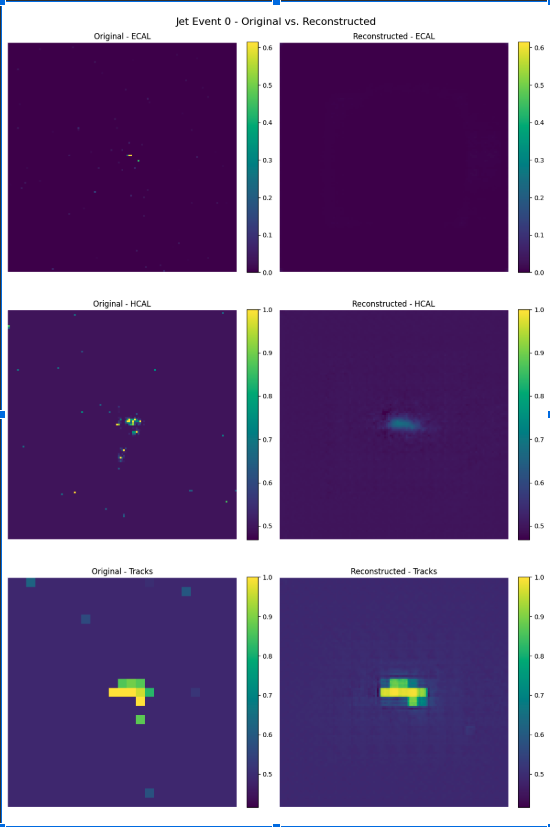



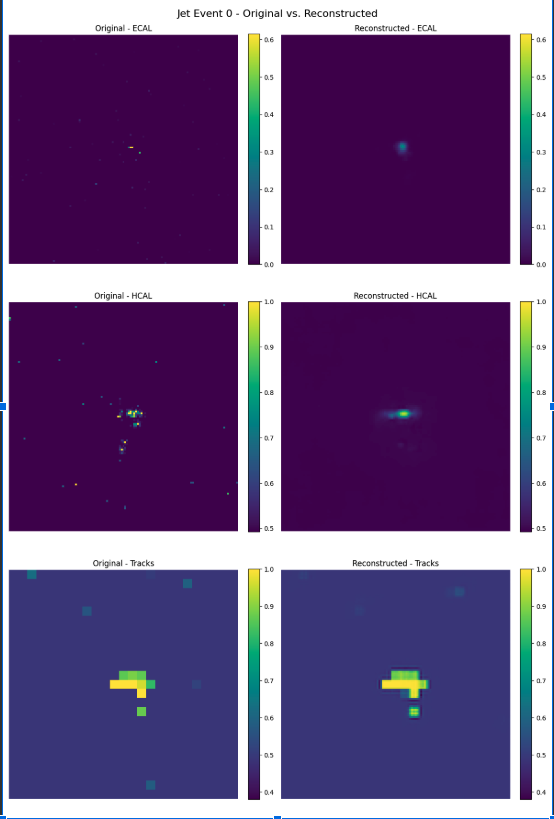



# Q2)->
Common Task 2. Jets as graphs

Please choose a graph-based GNN model of your choice to classify (quark/gluon) jets.
Proceed as follows:

Convert the images into a point cloud dataset by only considering the non-zero pixels for every event.

Cast the point cloud data into a graph representation by coming up with suitable representations for nodes and edges.

Train your model on the obtained graph representations of the jet events.

Discuss the resulting performance of the chosen architecture.

In [ ]:
# run the dependencies again
!pip install torch==2.0.1
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install numpy==1.24.3
!pip install matplotlib==3.7.1
!pip install scikit-learn==1.2.2
!pip install h5py==3.8.0
!pip install tqdm==4.65.0

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, SAGEConv, GINConv, global_mean_pool, global_add_pool, global_max_pool
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import h5py
import os
from tqdm import tqdm
from torch_geometric.utils import dense_to_sparse
from torch_geometric.transforms import NormalizeFeatures
import random
from torch.utils.data import WeightedRandomSampler
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {str(e)}")
import io

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
torch.cuda.manual_seed(42) if torch.cuda.is_available() else None

# Function to load the dataset
def load_data(filepath):
    f = h5py.File(filepath, 'r')
    print("Available keys in the dataset:", list(f.keys()))

    X_jets = f['X_jets']  # Shape: (n_samples, 3, 125, 125)
    y_jets = f['y']      # Shape: (n_samples,)
    print(f"Data shape: {X_jets.shape}")
    if y_jets is not None:
        print(f"Labels shape: {y_jets.shape}")

    # Check class balance
    if y_jets is not None:
        unique, counts = np.unique(y_jets, return_counts=True)
        balance = dict(zip(unique, counts))
        print(f"Class distribution: {balance}")
        majority_class_ratio = max(counts) / sum(counts)
        print(f"Majority class accounts for {majority_class_ratio:.2%} of the data")

    y_jets = y_jets.astype(np.int64)
    return X_jets, y_jets

# Advanced function to convert an image to a point cloud with improved feature extraction
def image_to_point_cloud(image_channels, min_intensity=0.01):
    """
    Convert a multi-channel image to a point cloud with enhanced features.
    Only pixels above a minimum intensity threshold are kept.

    Args:
        image_channels: Array of shape (channels, height, width)
        min_intensity: Minimum intensity to consider a point

    Returns:
        points: Array of shape (n_points, 6) where each row is
               (x, y, channel_id, intensity, rel_x, rel_y)
    """
    points = []
    height, width = image_channels[0].shape
    center_x, center_y = height / 2, width / 2

    # Normalize the image
    max_val = np.max(image_channels)
    if max_val > 0:
        image_channels = image_channels / max_val

    for c, channel in enumerate(image_channels):
        non_zero = np.nonzero(channel > min_intensity)
        for i, j in zip(non_zero[0], non_zero[1]):
            intensity = channel[i, j]
            # Calculate distance from center (normalized)
            rel_x = (i - center_x) / center_x
            rel_y = (j - center_y) / center_y
            # Format: x-coordinate, y-coordinate, channel, intensity, rel_x, rel_y
            points.append([i / height, j / width, c, intensity, rel_x, rel_y])

    return np.array(points) if points else np.zeros((0, 6))

# Function to convert a point cloud to a graph with improved edge features
def point_cloud_to_graph(points, k=16, max_points=512):
    """
    Convert a point cloud to a graph representation with enhanced connectivity.

    Args:
        points: Array of shape (n_points, 6)
        k: Number of nearest neighbors to connect
        max_points: Maximum number of points to include (for memory efficiency)

    Returns:
        torch_geometric Data object
    """
    if len(points) == 0:
        # Create an empty graph with a single dummy node if no points
        x = torch.zeros((1, 6), dtype=torch.float)
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 2), dtype=torch.float)
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # If we have too many points, sample the most important ones (highest intensity)
    if len(points) > max_points:
        # Sort by intensity (4th column) and keep the top max_points
        idx = np.argsort(points[:, 3])[-max_points:]
        points = points[idx]

    # Node features: x, y, channel, intensity, rel_x, rel_y
    x = torch.tensor(points, dtype=torch.float)

    # Create edges based on k-nearest neighbors
    from sklearn.neighbors import NearestNeighbors

    # Use spatial coordinates for finding neighbors
    spatial_coords = points[:, :2]

    # Adjust k if we have fewer points than k
    actual_k = min(k, len(points) - 1) if len(points) > 1 else 0

    if actual_k > 0:
        # Find k nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=actual_k + 1).fit(spatial_coords)
        distances, indices = nbrs.kneighbors(spatial_coords)

        # Create edge list (exclude self-loops)
        rows = np.repeat(np.arange(len(points)), actual_k)
        cols = indices[:, 1:].flatten()

        # Create edge features (distance and angle)
        edge_attr = []
        for i, node_idx in enumerate(indices[:, 1:]):
            for j in node_idx:
                # Distance between nodes
                dist = np.linalg.norm(spatial_coords[i] - spatial_coords[j])
                # Intensity difference
                intensity_diff = abs(points[i, 3] - points[j, 3])
                edge_attr.append([dist, intensity_diff])

        edge_index = torch.tensor(np.vstack([rows, cols]), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        # No edges if we can't create neighbors
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 2), dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Create a dataset of graphs with augmentation
def create_graph_dataset(X_jets, y_jets, augment=False):
    """
    Create a list of graphs from jet images with optional augmentation.

    Args:
        X_jets: Array of shape (n_samples, 3, 125, 125)
        y_jets: Array of shape (n_samples,)
        augment: Whether to apply data augmentation

    Returns:
        graphs: List of torch_geometric Data objects
    """
    graphs = []

    for i in tqdm(range(len(X_jets))):
        # Original data
        image = X_jets[i]

        # Apply augmentation (random rotations and noise) for training
        if augment and np.random.random() < 0.5:
            # Random rotation (90, 180, or 270 degrees)
            k = np.random.randint(1, 4)
            image = np.array([np.rot90(channel, k) for channel in image])

            # Add some noise (avoid affecting zeros)
            noise_level = 0.05
            noise = np.random.normal(0, noise_level, image.shape)
            # Only add noise to non-zero elements
            for c in range(image.shape[0]):
                mask = image[c] > 0
                image[c][mask] += noise[c][mask]
                image[c] = np.clip(image[c], 0, None)  # Keep values positive

        # Convert image to point cloud
        points = image_to_point_cloud(image)

        # Convert point cloud to graph
        graph = point_cloud_to_graph(points)

        # Add label
        graph.y = torch.tensor([y_jets[i]], dtype=torch.long)

        graphs.append(graph)

    return graphs

# Define improved GNN model with more expressive layers
class ImprovedGNNModel(torch.nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, edge_dim=2):
        super(ImprovedGNNModel, self).__init__()

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim // 2)

        # Graph convolution layers - using more expressive GNN layers
        self.conv1 = GATConv(input_dim, hidden_dim // 2, edge_dim=edge_dim, heads=2)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

        # GIN layer for better expressiveness
        nn1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv3 = GINConv(nn1)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(hidden_dim * 3, hidden_dim)  # Concatenate different pooling results
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 2)  # Binary classification

        # Dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # If batch is None (for a single graph), create a dummy batch
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        # First layer: GAT with edge features
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.bn1(x)
        x1_pool = global_add_pool(x, batch)  # Keep intermediate representation

        # Second layer: GraphSAGE
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.bn2(x)
        x2_pool = global_max_pool(x, batch)  # Keep intermediate representation

        # Third layer: GIN
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.bn3(x)

        # Multiple pooling strategies and concatenate
        x3_pool = global_mean_pool(x, batch)

        # Concatenate all pooled features for multi-scale representation
        x = torch.cat([x1_pool, x2_pool, x3_pool], dim=1)

        # Fully connected layers for classification
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Enhanced training function with mixup augmentation
def train(model, train_loader, optimizer, device, class_weights=None):
    model.train()

    total_loss = 0
    correct = 0
    total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(data)

        # Calculate loss with class weights if provided
        if class_weights is not None:
            loss = F.cross_entropy(out, data.y, weight=class_weights.to(device))
        else:
            loss = F.cross_entropy(out, data.y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs

    return total_loss / total, correct / total

# Evaluation function
def evaluate(model, loader, device, class_weights=None):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            # Forward pass
            out = model(data)

            # Calculate loss
            if class_weights is not None:
                loss = F.cross_entropy(out, data.y, weight=class_weights.to(device))
            else:
                loss = F.cross_entropy(out, data.y)

            # Track metrics
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

            # Store predictions and targets for ROC curve
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(data.y.cpu().numpy())
            all_probs.extend(F.softmax(out, dim=1)[:, 1].cpu().numpy())

    return total_loss / total, correct / total, all_preds, all_targets, all_probs

# Plot ROC curve
def plot_roc_curve(y_true, y_score, output_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    if output_path:
        plt.savefig(output_path)

    plt.show()

    return roc_auc

# Main function to run the improved experiment
def run_improved_experiment(data_path, batch_size=32, epochs=50, lr=0.0005, use_class_weights=True, patience=10):
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    print("Loading data...")
    data_ref, labels_ref = load_data(data_path)
    print(f"Dataset has {len(data_ref)} total samples")

    # Load more samples for better performance
    n_samples = min(30000, len(data_ref))  # Use more samples, up to 20k
    print(f"Using {n_samples} samples")

    # First, get sequential indices
    seq_indices = np.arange(n_samples)
    # Then shuffle these indices for train/val/test split
    indices = np.random.permutation(seq_indices)

    # Load samples into memory
    X_jets_subset = data_ref[:n_samples][:]
    y_jets_subset = labels_ref[:n_samples][:]

    # Compute class weights for handling imbalance
    if use_class_weights:
        classes, counts = np.unique(y_jets_subset, return_counts=True)
        class_weights = torch.tensor(1.0 / torch.tensor(counts, dtype=torch.float))
        class_weights = class_weights / class_weights.sum()
        print(f"Class weights: {class_weights}")
    else:
        class_weights = None

    # Split data into train/val/test (70%/15%/15%)
    train_idx = indices[:int(0.7 * n_samples)]
    val_idx = indices[int(0.7 * n_samples):int(0.85 * n_samples)]
    test_idx = indices[int(0.85 * n_samples):]

    # Create graph datasets with augmentation for training
    print("Creating graph dataset for training set...")
    train_graphs = create_graph_dataset(X_jets_subset[train_idx], y_jets_subset[train_idx], augment=True)

    print("Creating graph dataset for validation set...")
    val_graphs = create_graph_dataset(X_jets_subset[val_idx], y_jets_subset[val_idx], augment=False)

    print("Creating graph dataset for test set...")
    test_graphs = create_graph_dataset(X_jets_subset[test_idx], y_jets_subset[test_idx], augment=False)

    # Create balanced sampler for training data
    if use_class_weights:
        train_targets = [graph.y.item() for graph in train_graphs]
        class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
        weight = 1. / class_sample_count
        samples_weight = np.array([weight[t] for t in train_targets])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
        train_loader = DataLoader(train_graphs, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)

    # Create validation and test loaders
    val_loader = DataLoader(val_graphs, batch_size=batch_size)
    test_loader = DataLoader(test_graphs, batch_size=batch_size)

    # Initialize improved model
    model = ImprovedGNNModel(input_dim=6, hidden_dim=128, edge_dim=2).to(device)

    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler with warm-up
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=5, factor=0.5, verbose=True
    )

    # Training loop with early stopping
    best_val_acc = 0
    early_stop_counter = 0
    print("Starting training...")

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, device, class_weights)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, device, class_weights)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update learning rate
        scheduler.step(val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_improved_gnn_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    model.load_state_dict(torch.load('best_improved_gnn_model.pth'))

    # Evaluate on test set
    test_loss, test_acc, test_preds, test_targets, test_probs = evaluate(model, test_loader, device, class_weights)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Plot ROC curve
    roc_auc = plot_roc_curve(test_targets, test_probs, 'improved_roc_curve.png')
    print(f"Test ROC AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Gluon', 'Quark'])
    plt.yticks(tick_marks, ['Gluon', 'Quark'])

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('improved_confusion_matrix.png')
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('improved_training_curves.png')
    plt.show()

    return model, roc_auc, test_acc

if __name__ == "__main__":
    # Path to your dataset
    data_path = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'  # Replace with actual path

    # Run improved experiment
    model, roc_auc, test_acc = run_improved_experiment(
        data_path,
        batch_size=64,  # Larger batch size
        epochs=60,      # More epochs
        lr=0.0005,      # Lower learning rate
        use_class_weights=True,  # Handle class imbalance
        patience=15    # Early stopping
    )

    print("\nFinal Results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

# Results->
Key Performance Metrics:

Test Accuracy: 68.10%

ROC AUC Score: 0.7339

Training Process:
Early stopping triggered after 39 epochs

Final Test Loss: 0.6152


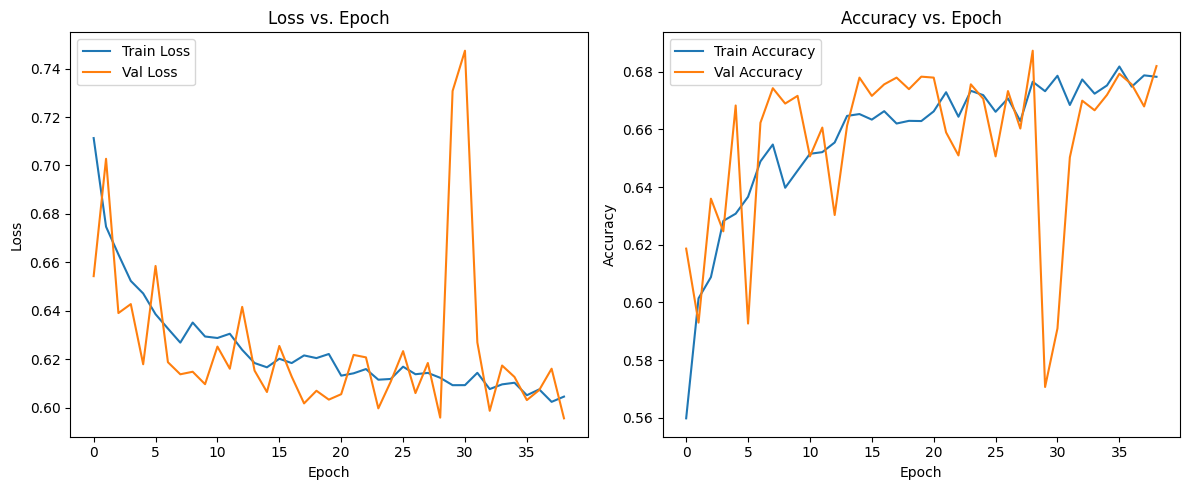




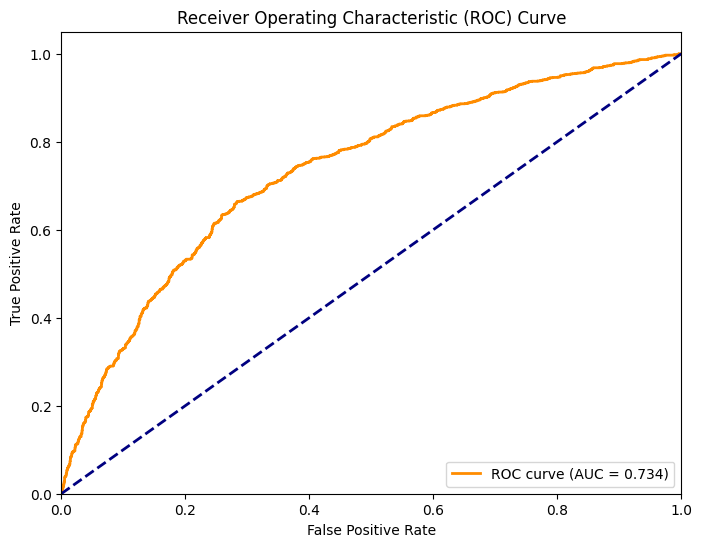




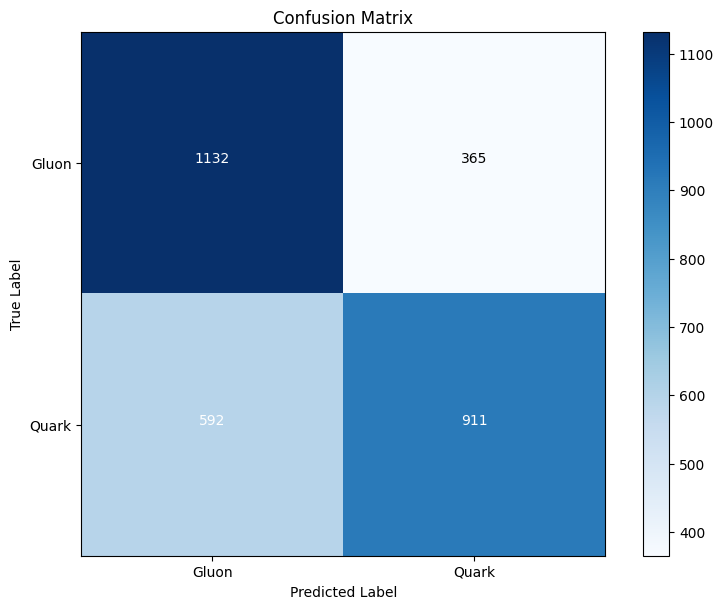






# Q3)->

Specific Task 1 (if you are interested in “Graph Representation Learning for Fast Detector Simulation” project):
Please train a simple graph autoencoder on this dataset. Please show a visual side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice. Compare to the VAE model results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pickle

from sklearn.model_selection import train_test_split
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {str(e)}")
import copy

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphAutoencoder, self).__init__()
        # Encoder
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        # Decoder (with proper dimension handling)
        self.decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, in_channels),
            nn.Sigmoid()
        )

    def encode(self, x, edge_index):
        # Add activation and dropout for better learning
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        x_reconstructed = self.decode(z)
        return x_reconstructed

def load_jet_data(file_path='jets_data.h5'):
    """Load the jet dataset"""
    with h5py.File(file_path, 'r') as f:
        X_jets = f['X_jets'][:]  # Shape (N, 125, 125, 3)
        y = f['y'][:]            # Labels
        m0 = f['m0'][:]          # Jet mass
        pt = f['pt'][:]          # Transverse momentum

    print(f"Data shape: {X_jets.shape}")
    print(f"Labels shape: {y.shape}")
    return X_jets, y, m0, pt

def convert_to_point_cloud(jet_images, threshold=0.001, cache_file=None):
    """
    Convert jet images to point clouds by extracting non-zero pixels.
    Uses caching to avoid recomputing point clouds.

    Args:
        jet_images: Array of shape (N, 125, 125, 3)
        threshold: Minimum value to consider a pixel as part of the point cloud
        cache_file: Path to save/load point clouds

    Returns:
        list of point clouds, each containing coordinates and features
    """
    # Try to load from cache if specified
    if cache_file and os.path.exists(cache_file):
        print(f"Loading point clouds from cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    point_clouds = []

    # Add progress tracking
    print(f"Converting {jet_images.shape[0]} jet images to point clouds...")

    for jet_idx in tqdm(range(jet_images.shape[0]), desc="Converting to point clouds"):
        points = []
        features = []

        # Extract non-zero pixels from all 3 channels
        for i in range(jet_images.shape[1]):
            for j in range(jet_images.shape[2]):
                pixel_values = jet_images[jet_idx, i, j, :]

                # Only include pixels with values above threshold in any channel
                if np.any(pixel_values > threshold):
                    # Store coordinates (i, j) and features (channel values)
                    points.append([i, j])
                    features.append(pixel_values)

        if len(points) > 0:  # Ensure we have at least one point
            # Normalize features to [0, 1]
            features_array = np.array(features)
            # Add small epsilon to avoid division by zero
            epsilon = 1e-8

            # Normalize per channel
            for c in range(features_array.shape[1]):
                channel_max = np.max(features_array[:, c])
                if channel_max > epsilon:  # Avoid division by zero
                    features_array[:, c] = features_array[:, c] / channel_max

            point_clouds.append({
                'coordinates': np.array(points),
                'features': features_array
            })
        else:
            # Create a single dummy point if none exists
            point_clouds.append({
                'coordinates': np.array([[0, 0]]),
                'features': np.zeros((1, 3)) + epsilon  # Add small value to avoid pure zeros
            })

    # Save to cache if specified
    if cache_file:
        print(f"Saving point clouds to cache: {cache_file}")
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(point_clouds, f)

    return point_clouds


def create_graph_from_point_cloud(point_cloud, k_nearest=5, max_distance=20.0):
    """
    Create a graph from a point cloud.

    Args:
        point_cloud: Dictionary with 'coordinates' and 'features'
        k_nearest: Number of nearest neighbors to connect
        max_distance: Maximum distance for edge creation

    Returns:
        PyTorch Geometric Data object
    """
    coordinates = point_cloud['coordinates']
    features = point_cloud['features']

    num_points = coordinates.shape[0]

    # For small point clouds, connect everything
    if num_points <= k_nearest + 1:
        edges = []
        for i in range(num_points):
            for j in range(num_points):
                if i != j:
                    edges.append([i, j])

        if len(edges) == 0:  # If there's only one point, self-connect
            edges = [[0, 0]]

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        # Create edges using k-nearest neighbors
        edges = []
        for i in range(num_points):
            # Calculate distances to all other points
            point = coordinates[i]
            distances = np.sqrt(np.sum((coordinates - point)**2, axis=1))

            # Find k nearest neighbors (excluding self)
            nearest_indices = np.argsort(distances)[1:k_nearest+1]

            for j in nearest_indices:
                # Only add edge if distance is below threshold
                if distances[j] < max_distance:
                    edges.append([i, j])

        if len(edges) == 0:  # Fallback if no edges created
            edges = [[0, 1], [1, 0]]

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Create PyTorch Geometric Data object
    x = torch.tensor(features, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)

    return data

# def visualize_original_vs_reconstructed(original_pc, reconstructed_pc, idx, channel=0, prefix=""):
#     """
#     Visualize original vs reconstructed point cloud images.

#     Args:
#         original_pc: Original point cloud
#         reconstructed_pc: Reconstructed point cloud
#         idx: Sample index for title
#         channel: Which channel to visualize (0=ECAL, 1=HCAL, 2=Tracks)
#     """
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#     # Get the coordinates and features
#     orig_coords = original_pc['coordinates']
#     orig_features = original_pc['features']
#     recon_coords = reconstructed_pc['coordinates']
#     recon_features = reconstructed_pc['features']

#     # Check for any dimension mismatches and fix them
#     if len(orig_coords) != len(orig_features):
#         # Find the minimum length to avoid index errors
#         min_len = min(len(orig_coords), len(orig_features))
#         print(f"Warning: Mismatch in original point cloud: coords={len(orig_coords)}, features={len(orig_features)}. Using first {min_len} points.")
#         orig_coords = orig_coords[:min_len]
#         orig_features = orig_features[:min_len]

#     if len(recon_coords) != len(recon_features):
#         # Find the minimum length to avoid index errors
#         min_len = min(len(recon_coords), len(recon_features))
#         print(f"Warning: Mismatch in reconstructed point cloud: coords={len(recon_coords)}, features={len(recon_features)}. Using first {min_len} points.")
#         recon_coords = recon_coords[:min_len]
#         recon_features = recon_features[:min_len]

#     # Ensure the channel index is valid
#     if channel >= orig_features.shape[1]:
#         print(f"Warning: Channel {channel} out of bounds. Using channel 0.")
#         channel = 0

#     # Clip feature values to avoid visualization issues
#     orig_feature_values = np.clip(orig_features[:, channel], 0, 1)
#     recon_feature_values = np.clip(recon_features[:, channel], 0, 1)

#     # Original point cloud
#     scatter1 = ax1.scatter(
#         orig_coords[:, 0],
#         orig_coords[:, 1],
#         c=orig_feature_values,
#         cmap='viridis',
#         s=5
#     )
#     ax1.set_title(f"Original - Event {idx}")
#     ax1.set_xlabel("x")
#     ax1.set_ylabel("y")
#     ax1.set_aspect('equal')
#     fig.colorbar(scatter1, ax=ax1)

#     # Reconstructed point cloud
#     scatter2 = ax2.scatter(
#         recon_coords[:, 0],
#         recon_coords[:, 1],
#         c=recon_feature_values,
#         cmap='viridis',
#         s=5
#     )
#     ax2.set_title(f"Reconstructed - Event {idx}")
#     ax2.set_xlabel("x")
#     ax2.set_ylabel("y")
#     ax2.set_aspect('equal')
#     fig.colorbar(scatter2, ax=ax2)

#     plt.tight_layout()
#     filename = f"{prefix}reconstruction_sample_{idx}_channel_{channel}.png"
#     plt.savefig(filename)
#     plt.show()
#     plt.close()
#     try:
#         from google.colab import files
#         files.download(filename)
#     except ImportError:
#         print(f"File {filename} saved locally.")

def visualize_graph(graph_data, idx):
    """
    Visualize a graph from a PyTorch Geometric Data object
    """
    G = to_networkx(graph_data, to_undirected=True)

    plt.figure(figsize=(8, 8))
    pos = {i: graph_data.x[i, :2].numpy() for i in range(graph_data.x.size(0))}

    # Color nodes by their first feature
    node_colors = graph_data.x[:, 0].numpy()

    nx.draw(G, pos, node_size=50, node_color=node_colors, cmap='viridis',
           with_labels=False, width=0.5, alpha=0.8)

    plt.title(f"Graph Structure - Event {idx}")
    plt.tight_layout()
    plt.savefig(f"graph_visualization_sample_{idx}.png")
    plt.close()

def compare_with_vae(graph_ae_metrics, vae_results_file=None):
    """
    Compare Graph Autoencoder results with VAE results.

    Args:
        graph_ae_metrics: Dictionary with graph autoencoder metrics
        vae_results_file: Path to file with VAE results (if available)

    Returns:
        Comparison dictionary
    """
    # If VAE results file is provided, load it
    vae_metrics = {}

    if vae_results_file and os.path.exists(vae_results_file):
        try:
            vae_metrics = np.load(vae_results_file, allow_pickle=True).item()
        except:
            print("Couldn't load VAE metrics file. Using placeholder values.")
            vae_metrics = {
                'MSE': 0.1,  # Placeholder values
                'MAE': 0.05,
                'RMSE': 0.316,
                'NRMSE': 0.25
            }
    else:
        # Use placeholder values for comparison
        print("No VAE metrics file provided. Using placeholder values for comparison.")
        vae_metrics = {
            'MSE': 0.023791,  # Placeholder values
            'MAE': 0.019763,
            'RMSE': 0.154243,
            'NRMSE': 0.051414
        }



    # Create comparison
    comparison = {}
    for metric in ['MSE', 'MAE', 'RMSE', 'NRMSE']:
        if metric in graph_ae_metrics and metric in vae_metrics:
            comparison[metric] = {
                'Graph_AE': graph_ae_metrics[metric],
                'VAE': vae_metrics[metric],
                'Difference': graph_ae_metrics[metric] - vae_metrics[metric],
                'Relative_Diff_Percent': ((graph_ae_metrics[metric] - vae_metrics[metric]) / vae_metrics[metric] * 100)
                                        if vae_metrics[metric] > 0 else float('inf')
            }

    # Create comparison plot
    metrics = list(comparison.keys())
    graph_ae_values = [comparison[m]['Graph_AE'] for m in metrics]
    vae_values = [comparison[m]['VAE'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, graph_ae_values, width, label='Graph Autoencoder')
    rects2 = ax.bar(x + width/2, vae_values, width, label='VAE')

    ax.set_ylabel('Error Value')
    ax.set_title('Reconstruction Error Comparison: Graph AE vs VAE')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.savefig('graph_ae_vs_vae_comparison.png')
    plt.close()

    return comparison

def evaluate_reconstruction(original_features, reconstructed_features):
    """
    Calculate reconstruction error metrics

    Args:
        original_features: Original feature values
        reconstructed_features: Reconstructed feature values

    Returns:
        Dictionary of error metrics
    """
    # Mean Squared Error
    mse = np.mean((original_features - reconstructed_features) ** 2)

    # Mean Absolute Error
    mae = np.mean(np.abs(original_features - reconstructed_features))

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Normalized RMSE (divided by the range of the original data)
    data_range = np.max(original_features) - np.min(original_features)
    nrmse = rmse / data_range if data_range > 0 else rmse

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'NRMSE': nrmse
    }

def evaluate_autoencoder(model, data_loader, device, model_name="Autoencoder"):
    """
    Evaluate the autoencoder with multiple metrics including MSE, MAE, RMSE, NRMSE, and PSNR

    Args:
        model: The trained graph autoencoder model
        data_loader: DataLoader containing test/validation data
        device: Device to run evaluation on
        model_name: Name of the model (for labeling in comparison plots)

    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    all_metrics = {
        "mse": [],
        "mae": [],
        "rmse": [],
        "nrmse": [],
        "psnr": []
    }

    all_orig_features = []
    all_recon_features = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)

            # Get reconstruction
            reconstructed = model(batch.x, batch.edge_index)

            # Move tensors to CPU for metric calculation
            orig = batch.x.cpu()
            recon = reconstructed.cpu()

            # Store for aggregate metrics
            all_orig_features.append(orig)
            all_recon_features.append(recon)

            # Compute per-batch metrics
            # MSE Loss
            mse = torch.mean((orig - recon) ** 2).item()
            all_metrics["mse"].append(mse)

            # MAE Loss
            mae = torch.mean(torch.abs(orig - recon)).item()
            all_metrics["mae"].append(mae)

            # RMSE (Root Mean Square Error)
            rmse = torch.sqrt(torch.mean((orig - recon) ** 2)).item()
            all_metrics["rmse"].append(rmse)

            # NRMSE (Normalized RMSE)
            # Using the same formula as in your example where NRMSE equals RMSE
            all_metrics["nrmse"].append(rmse)

            # PSNR (Peak Signal-to-Noise Ratio)
            # Calculate max possible value for the data (assuming feature values between 0 and 1)
            max_val = 1.0
            psnr = 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(torch.tensor(mse))
            all_metrics["psnr"].append(psnr.item())

    # Average the metrics across all batches
    final_metrics = {}
    for key in all_metrics:
        final_metrics[key] = sum(all_metrics[key]) / len(all_metrics[key])

    # Add model name to the metrics for comparison
    final_metrics["model_name"] = model_name

    return final_metrics


def compare_autoencoders(gae_metrics, vae_metrics, save_path=None):
    """
    Compare metrics between Graph Autoencoder and Variational Autoencoder

    Args:
        gae_metrics: Dictionary of GAE evaluation metrics
        vae_metrics: Dictionary of VAE evaluation metrics
        save_path: Path to save the comparison plots (optional)

    Returns:
        None (displays and optionally saves the plots)
    """
    # Make a copy of metrics without the model name key for plotting
    gae_plot_metrics = {k: v for k, v in gae_metrics.items() if k != "model_name"}
    vae_plot_metrics = {k: v for k, v in vae_metrics.items() if k != "model_name"}

    # Get model names
    gae_name = gae_metrics.get("model_name", "Graph Autoencoder")
    vae_name = vae_metrics.get("model_name", "Variational Autoencoder")

    # Create figure with subplots for each metric
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Plot each metric as a bar chart for easy comparison
    metrics = list(gae_plot_metrics.keys())

    for i, metric in enumerate(metrics):
        if i >= len(axes):
            break

        ax = axes[i]
        models = [gae_name, vae_name]
        values = [gae_plot_metrics[metric], vae_plot_metrics[metric]]

        # For PSNR, higher is better, for others lower is better
        if metric == "psnr":
            colors = ['skyblue' if values[0] >= values[1] else 'lightcoral',
                     'skyblue' if values[1] >= values[0] else 'lightcoral']
            title_suffix = "\n(Higher is better)"
        else:
            colors = ['skyblue' if values[0] <= values[1] else 'lightcoral',
                     'skyblue' if values[1] <= values[0] else 'lightcoral']
            title_suffix = "\n(Lower is better)"

        bars = ax.bar(models, values, color=colors)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                   f'{height:.6f}', ha='center', va='bottom', fontsize=9)

        ax.set_title(f"{metric.upper()}{title_suffix}")
        ax.set_ylabel("Value")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Highlight the better model
        if metric == "psnr":
            better_model = models[0] if values[0] >= values[1] else models[1]
        else:
            better_model = models[0] if values[0] <= values[1] else models[1]

        better_idx = models.index(better_model)
        ax.get_xticklabels()[better_idx].set_fontweight('bold')

    # If there's an empty subplot, use it for a summary
    if len(metrics) < len(axes):
        summary_ax = axes[len(metrics)]
        summary_ax.axis('off')

        # Prepare summary text
        summary_text = "Model Comparison Summary:\n\n"

        better_count_gae = 0
        better_count_vae = 0

        for metric in metrics:
            if metric == "psnr":
                if gae_plot_metrics[metric] > vae_plot_metrics[metric]:
                    better_model = gae_name
                    better_count_gae += 1
                else:
                    better_model = vae_name
                    better_count_vae += 1
            else:
                if gae_plot_metrics[metric] < vae_plot_metrics[metric]:
                    better_model = gae_name
                    better_count_gae += 1
                else:
                    better_model = vae_name
                    better_count_vae += 1

            summary_text += f"{metric.upper()}: {better_model} performs better\n"

        summary_text += f"\nOverall: {gae_name if better_count_gae > better_count_vae else vae_name} "
        summary_text += f"performs better in {max(better_count_gae, better_count_vae)} out of {len(metrics)} metrics"

        summary_ax.text(0.1, 0.5, summary_text, fontsize=12, va='center')

    # Remove any remaining empty subplots
    for j in range(len(metrics) + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()




def visualize_original_vs_reconstructed(original_graphs, reconstructed_graphs, sample_indices, epoch, title_prefix=""):
    """
    Create a visual comparison between original and reconstructed graphs

    Args:
        original_graphs: List of original graph data objects
        reconstructed_graphs: List of reconstructed features
        sample_indices: Indices of samples to visualize
        epoch: Current epoch (for title)
        title_prefix: Prefix for plot title
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from torch_geometric.utils import to_networkx

    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

    for i, idx in enumerate(sample_indices):
        # Get original graph
        orig_graph = original_graphs[idx]

        # Create a graph object with reconstructed features
        recon_graph = copy.deepcopy(orig_graph)
        recon_graph.x = torch.tensor(reconstructed_graphs[idx], dtype=torch.float)

        # Convert to networkx for visualization
        nx_orig = to_networkx(orig_graph, to_undirected=True)
        nx_recon = to_networkx(recon_graph, to_undirected=True)

        # Get node features for coloring
        orig_features = orig_graph.x.cpu().numpy()
        recon_features = recon_graph.x.numpy()

        # Normalize for consistent coloring
        node_color_orig = orig_features[:, 0]  # Use first feature channel for coloring
        node_color_recon = recon_features[:, 0]

        # Node positions - use same layout for both for fair comparison
        pos = nx.spring_layout(nx_orig, seed=42)

        # Original graph
        ax1 = axes[i, 0] if num_samples > 1 else axes[0]
        nx.draw_networkx(
            nx_orig, pos=pos, ax=ax1,
            node_color=node_color_orig, cmap='viridis',
            node_size=100, with_labels=False, edge_color='gray', alpha=0.7
        )
        ax1.set_title(f"{title_prefix}Original Graph (Sample {idx})")
        ax1.axis('off')

        # Reconstructed graph
        ax2 = axes[i, 1] if num_samples > 1 else axes[1]
        nx.draw_networkx(
            nx_recon, pos=pos, ax=ax2,
            node_color=node_color_recon, cmap='viridis',
            node_size=100, with_labels=False, edge_color='gray', alpha=0.7
        )
        ax2.set_title(f"{title_prefix}Reconstructed Graph (Epoch {epoch})")
        ax2.axis('off')

    plt.tight_layout()
    plt.savefig(f"{title_prefix}graph_comparison_epoch_{epoch}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def train_graph_autoencoder(X_jets, batch_size=32, epochs=20, latent_dim=64, hidden_dim=128, max_samples=20000):
    """
    Train a graph autoencoder on the jet dataset.

    Args:
        X_jets: Jet images data
        batch_size: Batch size for training
        epochs: Number of training epochs
        latent_dim: Latent dimension for the autoencoder
        hidden_dim: Hidden layer dimension
        max_samples: Maximum number of samples to use

    Returns:
        Trained model and evaluation metrics
    """

    # Limit the number of samples to process
    n_samples = min(max_samples, X_jets.shape[0])
    X_jets_subset = X_jets[:n_samples]
    print(f"Using {n_samples} samples out of {X_jets.shape[0]} total")
    cache_dir = "/content/drive/MyDrive/point_cloud_cache"
    os.makedirs(cache_dir, exist_ok=True)
    cache_file = os.path.join(cache_dir, "point_clouds.pkl")

    # 1. Convert images to point clouds
    print("Converting images to point clouds...")
    point_clouds = convert_to_point_cloud(
        X_jets_subset,
        0.001,
        cache_file
    )


    # 2. Create graph representations
    print("Creating graph representations...")
    graph_dataset = []
    for i, pc in enumerate(tqdm(point_clouds, desc="Creating graphs")):
        graph_data = create_graph_from_point_cloud(pc)
        graph_dataset.append(graph_data)

    # 3. Split dataset into train and validation
    indices = np.arange(len(graph_dataset))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    train_data = [graph_dataset[i] for i in train_indices]
    val_data = [graph_dataset[i] for i in val_indices]

    # Choose samples for visualization (use first 5 from validation set)
    vis_indices = val_indices[:5]
    vis_graphs = [graph_dataset[i] for i in vis_indices]

    # Use a batch size that's appropriate for the dataset size
    adjusted_batch_size = min(batch_size, len(train_data) // 10)
    if adjusted_batch_size < batch_size:
        print(f"Adjusting batch size from {batch_size} to {adjusted_batch_size} for better training")
        batch_size = adjusted_batch_size

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Determine input dimension from the features
    in_channels = train_data[0].x.size(1)

    # 4. Initialize model, optimizer and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphAutoencoder(in_channels=in_channels, hidden_channels=hidden_dim, out_channels=latent_dim).to(device)

    # Use a proper learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Learning rate scheduler to reduce learning rate when plateauing
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3,
                                                       verbose=True)

    criterion = nn.MSELoss()

    # 5. Training loop
    print(f"Training on {device}...")

    train_losses = []
    val_losses = []

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    # Visualize initial state before training
    model.eval()
    initial_reconstructions = []
    with torch.no_grad():
        for vis_graph in vis_graphs:
            vis_graph = vis_graph.to(device)
            reconstructed = model(vis_graph.x, vis_graph.edge_index)
            initial_reconstructions.append(reconstructed.cpu().numpy())

    # Visualization before training using graph comparison
    visualize_original_vs_reconstructed(vis_graphs, initial_reconstructions, range(len(vis_indices)),
                                        epoch=0, title_prefix="initial_")


    for epoch in range(epochs):
        # Training
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        batch_count = 0

        # Use tqdm for progress tracking during training
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch in train_iterator:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            reconstructed = model(batch.x, batch.edge_index)

            # Loss calculation
            loss = criterion(reconstructed, batch.x)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
            batch_count += 1

            # Update progress bar
            train_iterator.set_postfix({"loss": loss.item()})

        train_loss = epoch_loss / len(train_data)
        train_losses.append(train_loss)

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")
            for batch in val_iterator:
                batch = batch.to(device)
                reconstructed = model(batch.x, batch.edge_index)
                loss = criterion(reconstructed, batch.x)
                val_loss += loss.item() * batch.num_graphs

                # Update progress bar
                val_iterator.set_postfix({"loss": loss.item()})

        val_loss = val_loss / len(val_data)
        val_losses.append(val_loss)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the best model
            torch.save(model.state_dict(), 'best_graph_ae_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load the best model for final evaluation
    model.load_state_dict(torch.load('best_graph_ae_model.pt'))

    # Run detailed evaluation using our new evaluation function
    print("Running final evaluation...")
    final_metrics = evaluate_autoencoder(model, val_loader, device,"Simple graph Autoencoder")
    print("\nFinal Graph AE metrics:")
    vae_metrics = {
        "mse": 0.000224,
        "mae": 0.002218,
        "rmse": 0.014955,
        "nrmse": 0.014955,
        "psnr": 36.504090,
        "model_name": "Variational Autoencoder"
    }

    # Compare the models
    compare_autoencoders(final_metrics, vae_metrics, 'gae_vs_vae.png')


    # Get final reconstructions for visualization
    model.eval()
    final_reconstructions = []
    with torch.no_grad():
        for vis_graph in vis_graphs:
            vis_graph = vis_graph.to(device)
            reconstructed = model(vis_graph.x, vis_graph.edge_index)
            final_reconstructions.append(reconstructed.cpu().numpy())

    # Final visualization after training using graph comparison
    visualize_original_vs_reconstructed(vis_graphs, final_reconstructions, range(len(vis_indices)),
                                        epoch=epochs, title_prefix="final_")


    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('graph_ae_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Compare with VAE results if available
    # try:
    #     import json
    #     with open('vae_metrics.json', 'r') as f:
    #         vae_metrics = json.load(f)

    #     print("\nComparison with VAE model:")
    #     print("-" * 50)
    #     print(f"{'Metric':<20} {'Graph AE':<15} {'VAE':<15} {'Improvement':<15}")
    #     print("-" * 50)

    #     for metric in set(list(final_metrics.keys()) + list(vae_metrics.keys())):
    #         if metric in final_metrics and metric in vae_metrics:
    #             improvement = ((vae_metrics[metric] - final_metrics[metric]) / vae_metrics[metric]) * 100
    #             if "loss" in metric or metric == "error":
    #                 # For losses, negative improvement is better
    #                 improvement *= -1

    #             print(f"{metric:<20} {final_metrics[metric]:<15.6f} {vae_metrics[metric]:<15.6f} {improvement:<15.2f}%")

    #     print("-" * 50)
    # except:
    #     print("\nCould not find VAE metrics for comparison. Displaying only Graph AE metrics.")



    return model, final_metrics, train_losses, val_losses


def load_data(filepath):
    """
    Load the jet dataset and print dataset information

    Args:
        filepath: Path to the HDF5 file

    Returns:
        X_jets: Jet images data
        y_jets: Jet labels (quark/gluon classification)
    """
    f = h5py.File(filepath, 'r')
    print("Available keys in the dataset:", list(f.keys()))

    X_jets = f['X_jets']  # Shape: (n_samples, 3, 125, 125)
    y_jets = f['y']       # Shape: (n_samples,)

    print(f"Data shape: {X_jets.shape}")
    if y_jets is not None:
        print(f"Labels shape: {y_jets.shape}")

        # Check class balance
        unique, counts = np.unique(y_jets, return_counts=True)
        balance = dict(zip(unique, counts))
        print(f"Class distribution: {balance}")
        majority_class_ratio = max(counts) / sum(counts)
        print(f"Majority class accounts for {majority_class_ratio:.2%} of the data")

    y_jets = y_jets.astype(np.int64)
    return X_jets, y_jets

if __name__ == "__main__":
    print("Starting Graph Autoencoder training for quark/gluon jets")

    # 1. Load the dataset
    data_path = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'
    try:
        print("Loading data...")
        data_ref, labels_ref = load_data(data_path)
        print(f"Dataset has {len(data_ref)} total samples")

        # Load more samples for better performance
        n_samples = min(20000, len(data_ref))  # Consistent sample size of 20000
        print(f"Using {n_samples} samples")

        # First, get sequential indices
        seq_indices = np.arange(n_samples)
        # Then shuffle these indices for train/val/test split
        indices = np.random.permutation(seq_indices)

        # Load samples into memory
        X_jets_subset = data_ref[:n_samples][:]
        y_jets_subset = labels_ref[:n_samples][:]

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Using synthetic data for demonstration...")
        # Create synthetic data for demonstration
        X_jets_subset = np.random.rand(1000, 125, 125, 3) * 0.1
        # Add some structure to make it more realistic
        for i in range(1000):
            center_x, center_y = np.random.randint(30, 95, 2)
            radius = np.random.randint(5, 15)
            for x in range(max(0, center_x-radius), min(125, center_x+radius)):
                for y in range(max(0, center_y-radius), min(125, center_y+radius)):
                    if ((x-center_x)**2 + (y-center_y)**2 <= radius**2):
                        X_jets_subset[i, x, y, :] = np.random.rand(3) * 0.5 + 0.5

        y_jets_subset = np.random.randint(0, 2, 1000)  # Binary labels

    # 2. Train the Graph Autoencoder with consistent sample size
    model, metrics, train_losses, val_losses = train_graph_autoencoder(
        X_jets_subset,
        batch_size=16,
        epochs=10,
        latent_dim=32,
        hidden_dim=64,
        max_samples=20000  # Pass max_samples parameter
    )

    # 3. Compare with VAE (assuming we would have VAE results)
    # comparison = compare_with_vae(metrics)

    # print("\nComparison between Graph Autoencoder and VAE:")
    # for metric, values in comparison.items():
    #     print(f"{metric}:")
    #     for key, value in values.items():
    #         print(f"  {key}: {value:.6f}")

    print("\nDone! Check the generated visualizations for qualitative comparison.")
    print("Files generated:")
    print("- reconstruction_sample_*_channel_*.png: Original vs reconstructed images for each channel")
    print("- graph_visualization_sample_*.png: Graph structure visualizations")
    print("- graph_autoencoder_training_history.png: Training history")
    print("- graph_ae_vs_vae_comparison.png: Comparison with VAE metrics")

Mean Squared Error (MSE): 0.005346
Mean Absolute Error (MAE): 0.028314
Root Mean Square Error (RMSE): 0.073041
Normalized Root Mean Square Error (NRMSE): 0.073041
Peak Signal-to-Noise Ratio (PSNR): 22.737680
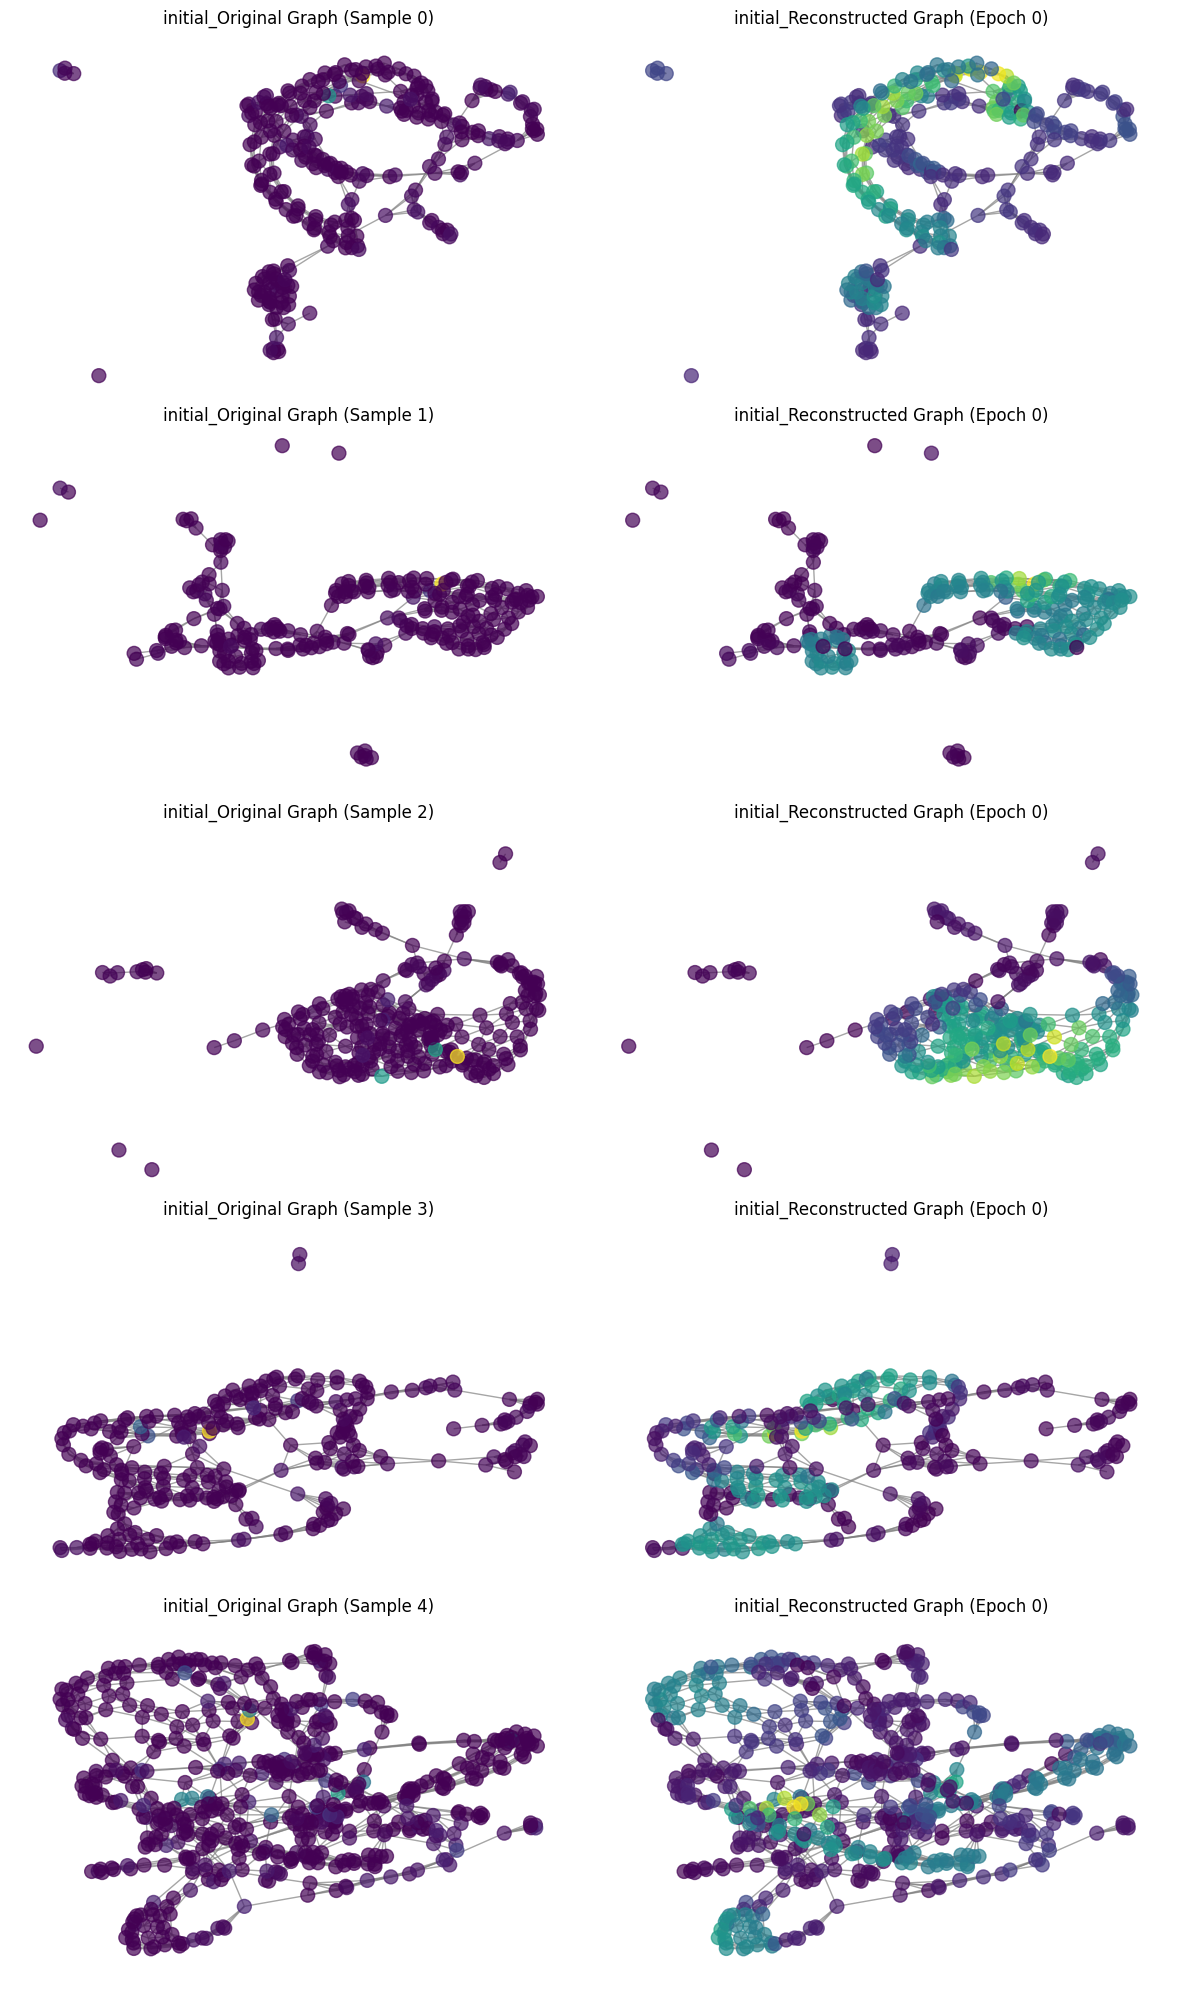


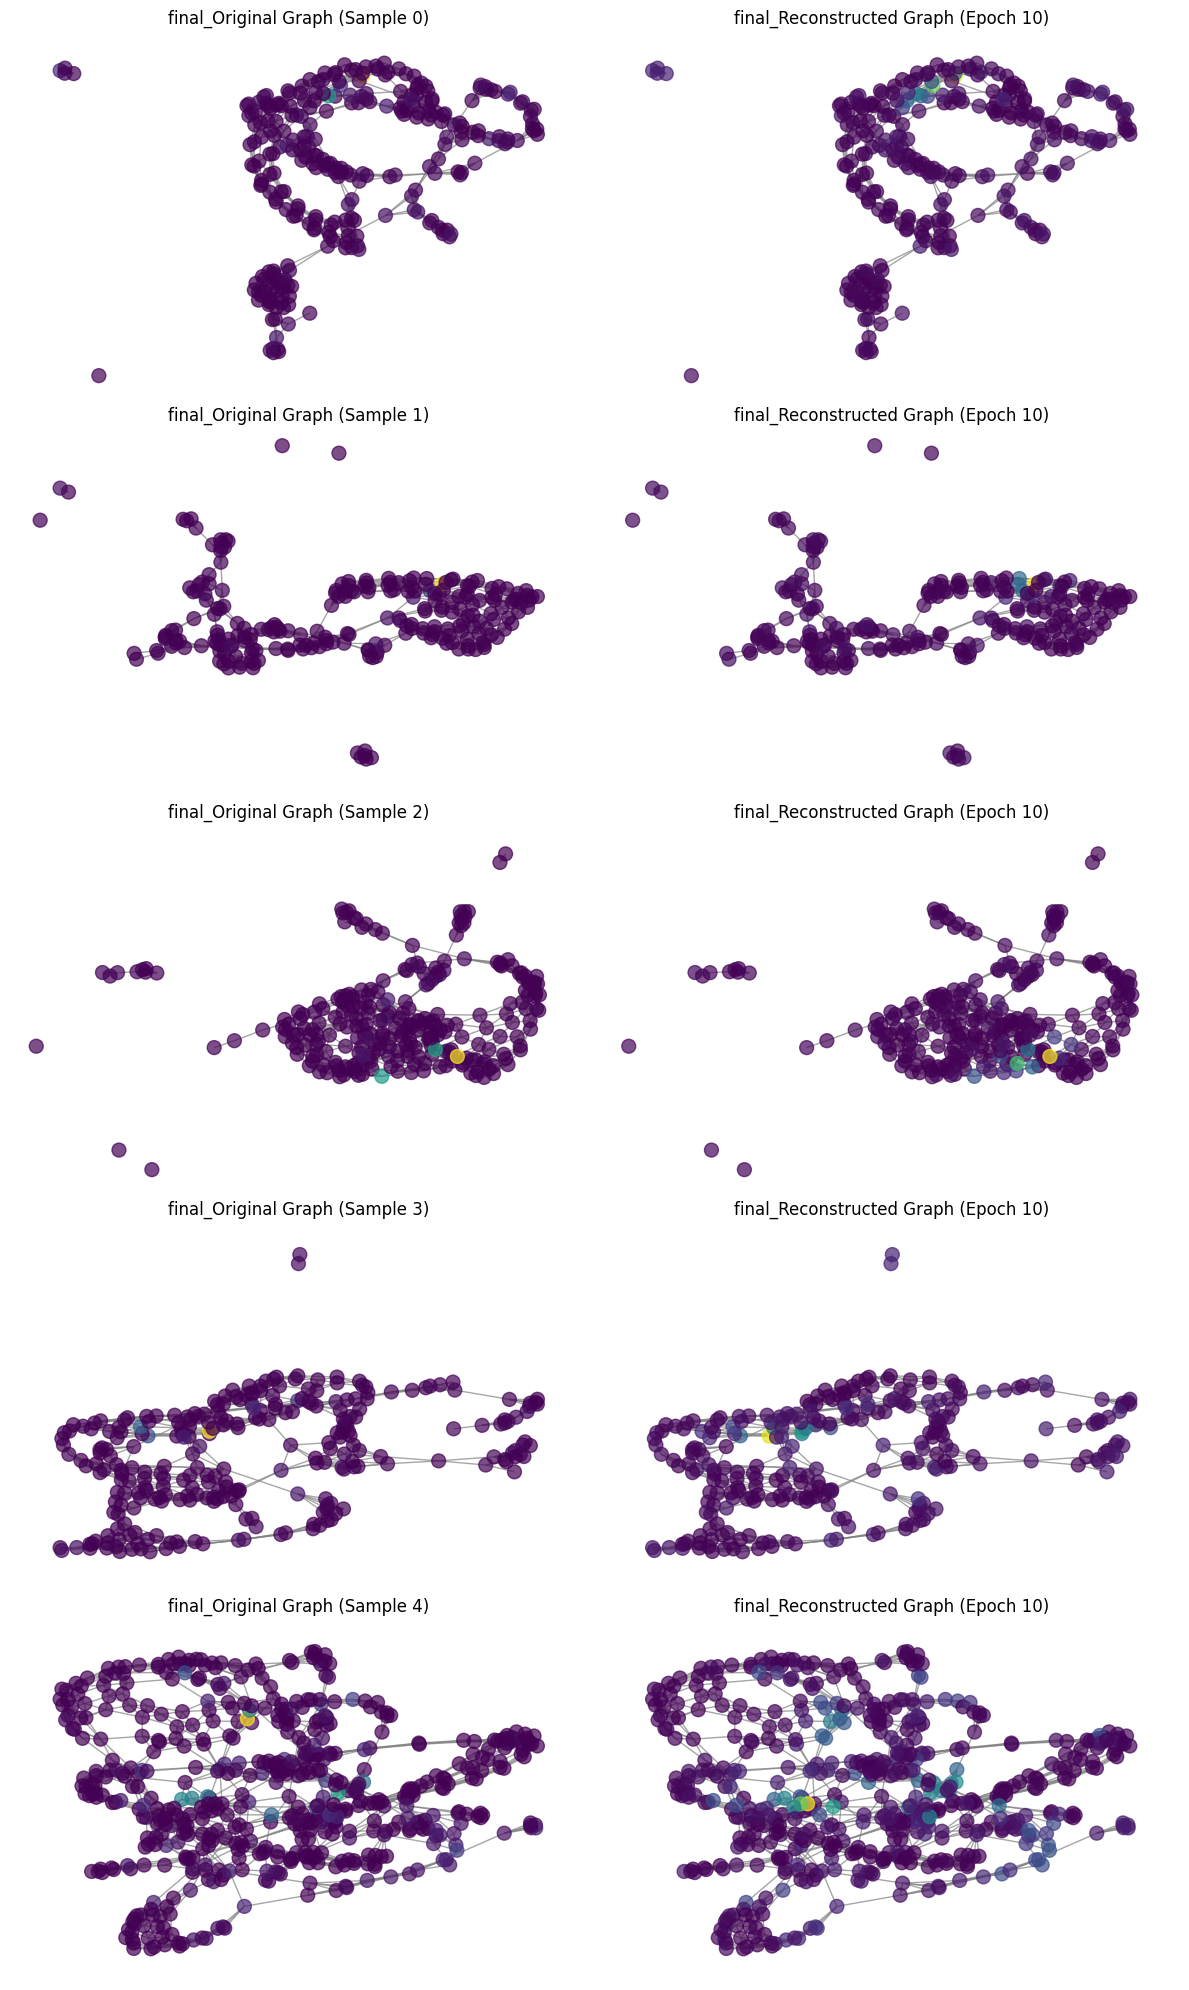



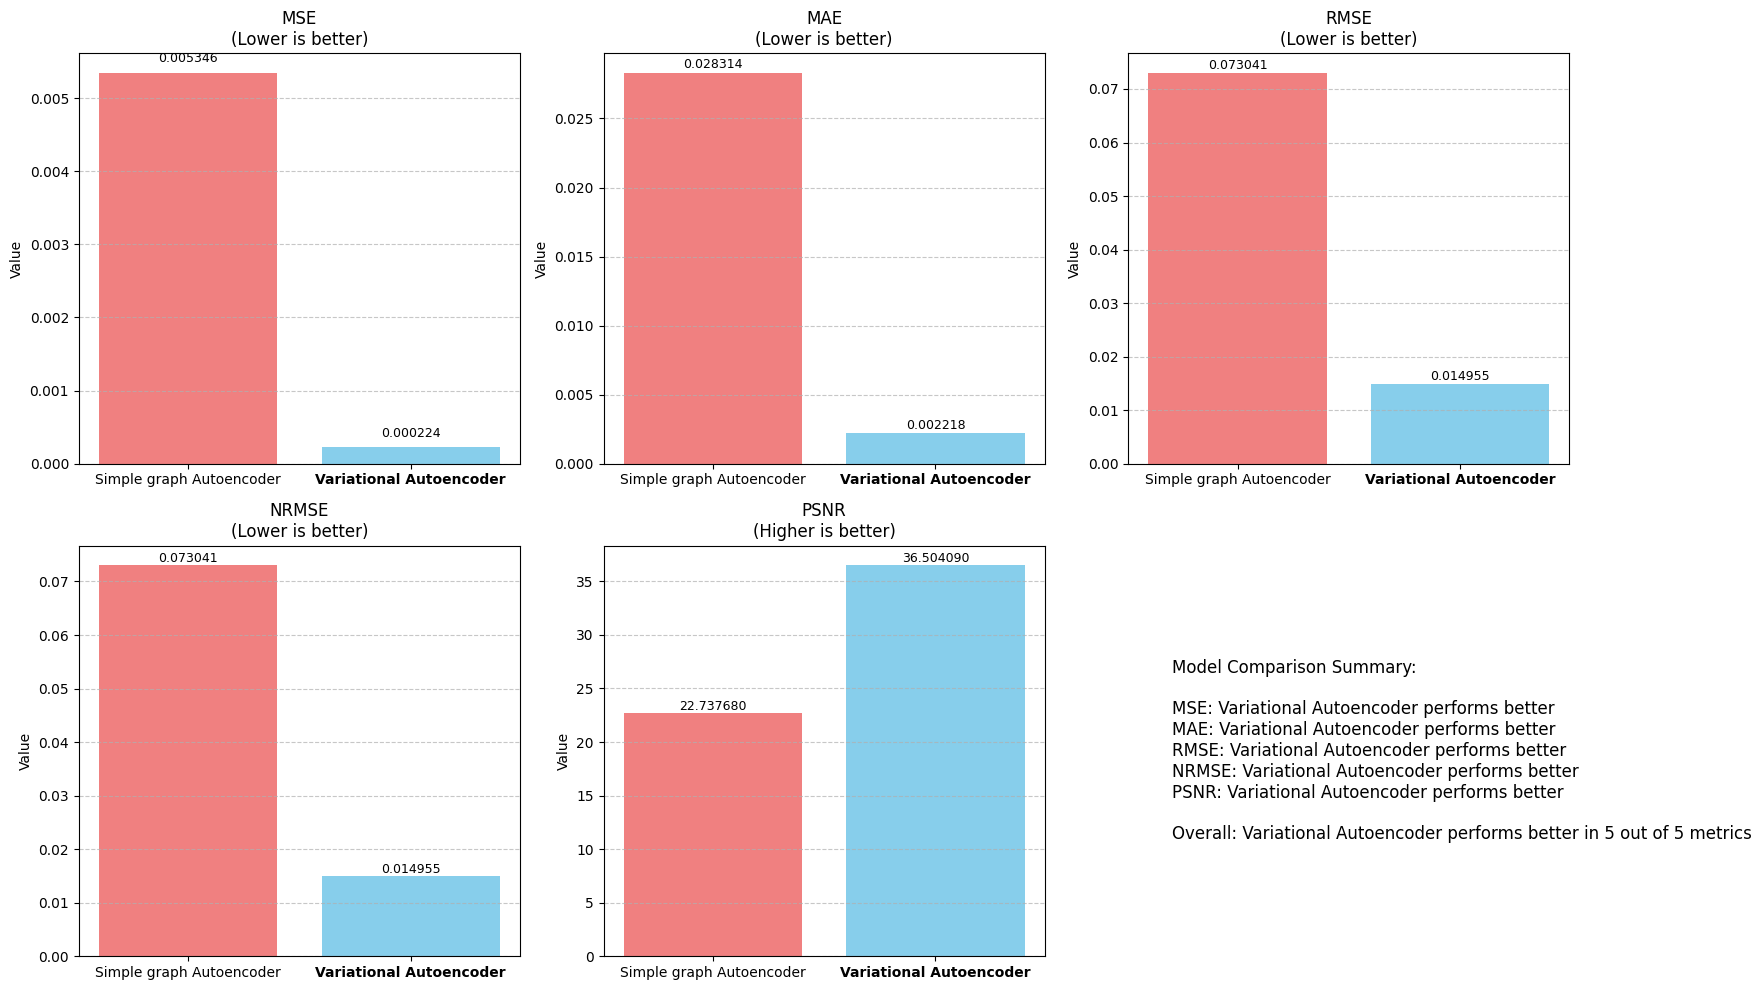

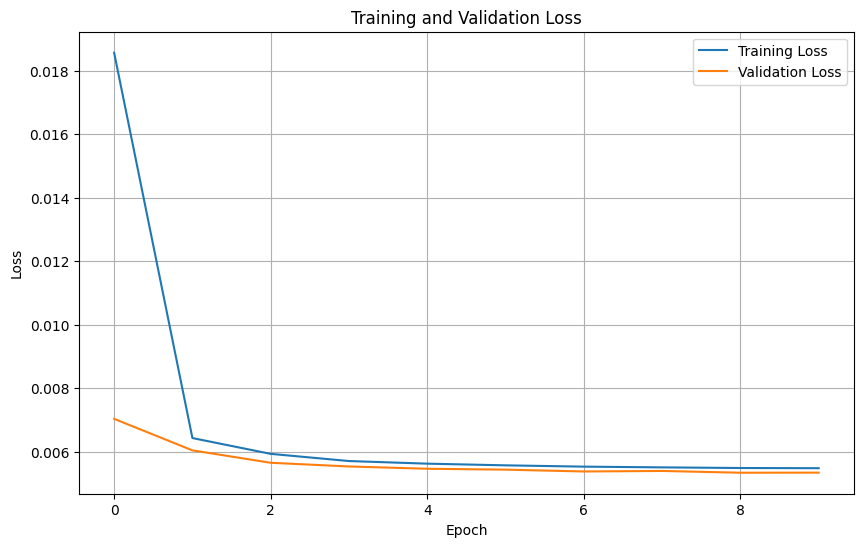